In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set(color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr#Pearson correlation coefficient
from sklearn.decomposition import randomized_svd
from scipy.signal import find_peaks
import scipy.optimize as opt

#import tensorly as tl#use tensorly to do tensor decompostion
#from tensorly.decomposition import parafac
#tl.set_backend('numpy') # or any other backend

import datetime
import time
#import winsound#sound alarm when code finishes, only in windows

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(1)

torch.backends.cudnn.deterministic=True
np.random.seed(1)
torch.manual_seed(1)    # reproducible

In [3]:
# for plot figures
plt.rcParams.update({'figure.max_open_warning': 0})
#Output matplotlib figure to SVG with text as text, not curves
plt.rcParams['svg.fonttype'] = 'none'
# axis spine
#use it like: adjust_spines(ax, ['left', 'bottom'])
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 2))  # outward by 2 points
            #spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [4]:
training_inputs = np.load('../data/fig3_training_inputs.npy')
training_set = np.load('../data/fig3_training_set.npy')
test_inputs = np.load('../data/fig3_test_inputs.npy')
test_set = np.load('../data/fig3_test_set.npy')

In [5]:
#split original training data into two parts, training loader: 2200, validation loader: 200
#make the dataset suitable for pytorch
train_loader=[]
for ii in range(0,2200,110):
    temp0=training_inputs[ii:ii+110] -0.5 #center the stimulus
    temp1=training_set[ii:ii+110]#100*200(neurons)
    temp=(temp0,temp1)
    train_loader.append(temp)

temp0=training_inputs[2200:] -0.5 #center the stimulus
temp1=training_set[2200:]#200*200(neurons)
val_loader=(temp0,temp1)

temp0=np.copy(test_inputs) -0.5 #center the stimulus
temp1=np.copy(test_set)#50*200(neurons)
test_loader=(temp0,temp1)

print ('length of train_loader:')
print (len(train_loader))
print ('shape of train_loader[0][0]:')
print (train_loader[0][0].shape)
print ('shape of train_loader[0][1]:')
print (train_loader[0][1].shape)
print ('shape of val_loader[0]:')
print (val_loader[0].shape)
print ('shape of val_loader[1]:')
print (val_loader[1].shape)
print ('shape of test_loader[0]:')
print (test_loader[0].shape)
print ('shape of test_loader[1]:')
print (test_loader[1].shape)

length of train_loader:
20
shape of train_loader[0][0]:
(110, 2, 8, 28, 28)
shape of train_loader[0][1]:
(110, 96)
shape of val_loader[0]:
(200, 2, 8, 28, 28)
shape of val_loader[1]:
(200, 96)
shape of test_loader[0]:
(50, 2, 8, 28, 28)
shape of test_loader[1]:
(50, 96)


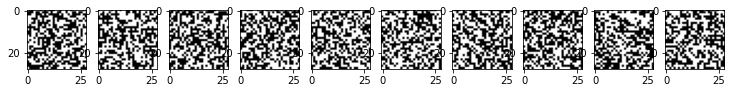

In [6]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(train_loader[0][0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

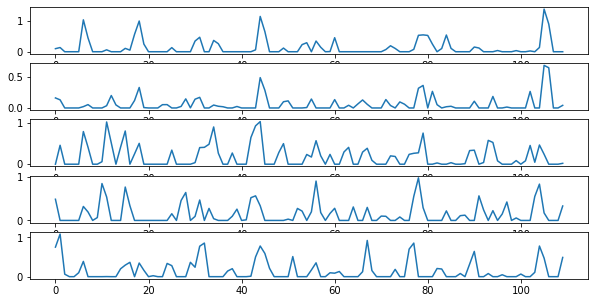

In [7]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(train_loader[0][1][:,ii])

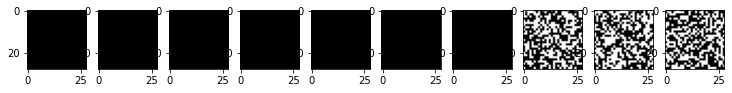

In [8]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(test_loader[0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

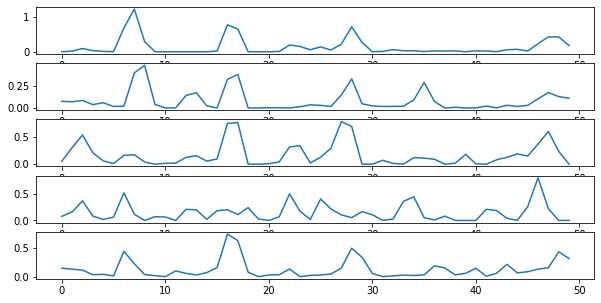

In [9]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(test_loader[1][:,ii])
    #axes[ii].grid(False)#axes[ii,jj].axis('tight')

In [10]:
#define train_loader_length and val_loader_length for function model_train()
train_loader_length=len(train_loader)
val_loader_length=len(val_loader[0])

In [11]:
#some help function
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

class Flatten3D(nn.Module):
    def forward(self, x):
        N, C, D, H, W = x.size() # read in N, C, D, H, W
        return x.view(N, -1)  # "flatten" the C *D* H * W values into a single vector per image

class Unflatten3D(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*D*H*W) and reshapes it
    to produce an output of shape (N, C, D,H, W).
    """
    def __init__(self, N=-1, C=128, D=7, H=7, W=7):
        super(Unflatten3D, self).__init__()
        self.N = N
        self.C = C
        self.D = D
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.D, self.H, self.W)
    
    
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)
def init_weights_Kaiming(m):
    if type(m) == nn.Linear or type(m) == nn.Conv3d or type(m) == nn.ConvTranspose3d\
    or type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        #torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.kaiming_uniform_(m.weight)

def loss_vae(recon_x, x, mu, logvar):
    tempN=x.shape[0]
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #return BCE + KLD
    return (MSE + KLD)/(tempN*10*2*56*56)#batch size tempN, to be comparable with other ae variants loss

loss_mse = nn.MSELoss()
#loss_ssim = pytorch_ssim.SSIM(window_size=3)

#loss with L2 and L1 regularizer
#something like loss = mseloss+ alpha*alpha_x(L2)+beta*beta_y(L1), here alpha_x is a list of model layers
def loss_L2L1(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempN=x.shape[0]
    MSE = F.mse_loss(recon_x, x,reduction='sum')
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(2)
    L2loss=alpha*l2temp
    L1loss=beta*F.l1_loss(beta_y,torch.zeros_like(beta_y),reduction='sum')
    return (MSE+L2loss+L1loss)/(tempN*10*2*56*56)#batch size tempN, to be comparable with other ae variants loss

#loss with L2 and L1 regularizer, version2
#something like loss = mseloss+ alpha*alpha_x(L2)+beta*beta_y(L1), here alpha_x is a list of model layers
def loss_L2L1v2(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempB, tempC, tempD, tempH, tempW =x.size()
    MSE = F.mse_loss(recon_x, x,reduction='sum')
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(2)
    L2loss=alpha*l2temp
    B, C, D, H, W = beta_y.size() # Batch*channel*depth*height*width
    temp1=beta_y.view(B,C,-1)
    temp2=torch.norm(temp1,p=2,dim=2)
    temp3=torch.sum(torch.abs(temp2))
    L1loss=beta*temp3
    #return (MSE+L2loss+L1loss)/(tempB* 2*10*12*12)#batch size tempN, to be comparable with other ae variants loss
    return (MSE+L2loss+L1loss)/(tempB* tempC* tempD* tempH* tempW)#to be comparable with other ae variants loss

#loss with L2 and L1 regularizer, for supervised encoded
#something like loss = mseloss+ alpha*alpha_x(L2)+beta*beta_y(L1), here alpha_x is a list of model layers
def loss_L2L1_SE(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempB, tempN =x.size()
    MSE = F.mse_loss(recon_x, x,reduction='sum')
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(2)
    L2loss=alpha*l2temp
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.weight.norm(1)
    L1loss=beta*l1temp
    return (MSE+L2loss+L1loss)/(tempB* tempN)
#loss with L2 and L1 regularizer, for supervised encoded, Poisson loss
#something like loss = Poissonloss+ alpha*alpha_x(L2)+beta*beta_y(L1), here alpha_x is a list of model layers
def Ploss_L2L1_SE(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempB, tempN =x.size()
    Ploss = F.poisson_nll_loss(recon_x, x,log_input=False, reduction='sum')
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(2)
    L2loss=alpha*l2temp
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.weight.norm(1)
    L1loss=beta*l1temp
    return (Ploss+L2loss+L1loss)/(tempB* tempN)
def Ploss_L2L1_SE2(recon_x, x, alpha, alpha2, beta, alpha_x, alpha_x2, beta_y): #different convkernels with different L2 penalty
    tempB, tempN =x.size()
    Ploss = F.poisson_nll_loss(recon_x, x,log_input=False, reduction='sum')
    #
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(2)
    L2loss=alpha*l2temp
    #
    l2temp2=0.0
    for temp in alpha_x2:
        l2temp2 = l2temp2 + temp.weight.norm(2)
    L2loss2=alpha2*l2temp2
    #
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.weight.norm(1)
    L1loss=beta*l1temp
    return (Ploss+L2loss+L2loss2+L1loss)/(tempB* tempN)
def Ploss_L2L1_SE_ST(recon_x, x, alpha1, alpha2, beta, alpha_x1, alpha_x2, beta_y): # for spatial and temporal separable model
    tempB, tempN =x.size()
    Ploss = F.poisson_nll_loss(recon_x, x,log_input=False, reduction='sum')
    l2temp=0.0
    for temp in alpha_x1:
        l2temp = l2temp+ temp.norm(2)
    l2temp2=0.0
    for temp in alpha_x2:
        l2temp2 = l2temp2+ temp.norm(2)
    L2loss=alpha1*l2temp+alpha2*l2temp2
    #
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.weight.norm(1)
    L1loss=beta*l1temp
    #return (Ploss+L2loss+L1loss)/(tempB* tempN)
    return Ploss+L2loss+L1loss
def loss_L1L1_SE(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempB, tempN =x.size()
    MSE = F.mse_loss(recon_x, x,reduction='sum')
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(1)
    L2loss=alpha*l2temp
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.weight.norm(1)
    L1loss=beta*l1temp
    return (MSE+L2loss+L1loss)/(tempB* tempN)

#loss with L2 and L1 regularizer, for supervised encoded, L2 for conv kernel smoothness
#something like loss = mseloss+ alpha*alpha_x(L2)+beta*beta_y(L1), here alpha_x is a list of model layers
def loss_L2lapL1_SE(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempB, tempN =x.size()
    MSE = F.mse_loss(recon_x, x,reduction='sum')
    l2temp=0.0
    laplacian=torch.tensor([[0.5,1.0,0.5],[1.0,-6.0,1.0],[0.5,1.0,0.5]], requires_grad=False)#laplacian kernel
    for temp in alpha_x:
        #l2temp = l2temp+ temp.weight.norm(2)
        NN,CC=temp.weight.shape[0],temp.weight.shape[1]
        laplacians=laplacian.repeat(CC, CC, 1, 1).requires_grad_(False).to(device)
        temp2=F.conv2d(temp.weight,laplacians)
        l2temp = l2temp+ temp2.norm(2)
    L2loss=alpha*l2temp
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.weight.norm(1)
    L1loss=beta*l1temp
    return (MSE+L2loss+L1loss)/(tempB* tempN)

#visualize DNN
#https://github.com/chongyangma/cs231n/blob/master/assignments/assignment3/NetworkVisualization-PyTorch.ipynb
#https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
#https://jacobgil.github.io/deeplearning/filter-visualizations
#https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030
#simple version: compute the gradient of the output channel wrt a blank image
#complex version: performa gradient ascend on the target channel, start with noise image
def vis_model_fl(model,device,xxshape):#visualize for final layer
    model=model.to(device)
    for param in model.parameters():
        param.requires_grad=False
    model=model.eval()
    (tempB,tempC,tempH,tempW)=xxshape#tempB should be equal to 1
    #xx=torch.randn((tempB,tempC,tempH,tempW),requires_grad=True)
    xx=torch.zeros((tempB,tempC,tempH,tempW),requires_grad=True)
    if xx.grad is not None:
        xx.grad.data.zero_()
    out=model(xx)
    outlen=out.shape[1]
    yy=torch.zeros(outlen,tempC,tempH,tempW)
    for ii in range(outlen):
        if xx.grad is not None:
            xx.grad.data.zero_()
        out=model(xx)
        temp=out[0,ii]
        temp.backward()
        yy[ii]=xx.grad.data
        #if xx.grad is not None:
        #    xx.grad.data.zero_()
    return yy
def vis_model_fl_3d(model,device,xxshape):#visualize for final layer
    model=model.to(device)
    for param in model.parameters():
        param.requires_grad=False
    model=model.eval()
    (tempB,tempC,tempD,tempH,tempW)=xxshape#tempB should be equal to 1
    #xx=torch.randn((tempB,tempC,tempH,tempW),requires_grad=True)
    xx=torch.zeros((tempB,tempC,tempD,tempH,tempW),requires_grad=True)
    if xx.grad is not None:
        xx.grad.data.zero_()
    out=model(xx)
    outlen=out.shape[1]
    yy=torch.zeros(outlen,tempC,tempD,tempH,tempW)
    for ii in range(outlen):
        if xx.grad is not None:
            xx.grad.data.zero_()
        out=model(xx)
        temp=out[0,ii]
        temp.backward()
        yy[ii]=xx.grad.data
        #if xx.grad is not None:
        #    xx.grad.data.zero_()
    return yy

#different preprocessing for different models
#x.shape: batchsize*10*2*56*56, x: bg, 1.0
#model: the model to be used, region: upper visual field (sky) or lower visual field (ground)
#region: sky or ground data
#pre_method: different preprocessing method, 'center': minus channel_mean, 'normalize': minus channel_mean then divided by
# the channel_std
def preprocess_np(x,model,pre_method,region):
    '''
    #some preprocessing if using model 'AutoEncoder3D_2'
    if model.__class__.__name__=='AutoEncoder3D_1':
        return x
    #for ae3D_2 or ae3D_3, subtrated by luminance mean value of each frame
    if model.__class__.__name__=='AutoEncoder3D_2' or \
        model.__class__.__name__=='AutoEncoder3D_3':
        for ii in range(x.shape[0]):
            for jj in range(x.shape[1]):
                for kk in range(x.shape[2]):
                    x[ii,jj,kk,:,:]=x[ii,jj,kk,:,:]-np.mean(x[ii,jj,kk,:,:])
        return x
    '''
    #for ae3D_4, subtrated by luminance mean value in color channel seperately across all frames
    #then divided by std. Because of memory proplem, this is done in make_dataset.py
    #std here actually is 'normalized' std
    if pre_method=='normalize' and region=='sky':
        x[:,0,:,:,:]=(x[:,0,:,:,:]-sky_bg_mean_f[0])/sky_bg_std_f[0]
        x[:,1,:,:,:]=(x[:,1,:,:,:]-sky_bg_mean_f[1])/sky_bg_std_f[1]
        return x
    if pre_method=='normalize' and region=='ground':
        x[:,0,:,:,:]=(x[:,0,:,:,:]-ground_bg_mean_f[0])/ground_bg_std_f[0]
        x[:,1,:,:,:]=(x[:,1,:,:,:]-ground_bg_mean_f[1])/ground_bg_std_f[1]
        return x
    #center the data, subtrated by luminance mean value in color channel seperately across all frames
    if pre_method=='center' and region=='sky':
        x[:,0,:,:,:]=x[:,0,:,:,:]-sky_bg_mean_f[0]
        x[:,1,:,:,:]=x[:,1,:,:,:]-sky_bg_mean_f[1]
        return x
    if pre_method=='center' and region=='ground':
        x[:,0,:,:,:]=x[:,0,:,:,:]-ground_bg_mean_f[0]
        x[:,1,:,:,:]=x[:,1,:,:,:]-ground_bg_mean_f[1]
        return x

#https://discuss.pytorch.org/t/where-is-the-noise-layer-in-pytorch/2887/4
'''
class GaussianNoise(nn.Module):
    def __init__(self, stddev=0.1):
        super().__init__()
        self.stddev = stddev

    def forward(self, din):
        if self.training:
            #return din + torch.autograd.Variable(torch.randn(din.size()).cuda() * self.stddev)
            return din + torch.autograd.Variable(torch.randn(din.size()).cuda() * self.stddev)
        return din
'''
class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        #self.noise = torch.tensor(0).to(device)
        #self.noise = torch.randn_like(input, dtype=None, device=device, requires_grad=False)

    def forward(self, x):
        if self.training and self.sigma != 0:
            #scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            #sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
            sampled_noise = torch.randn(x.size(),requires_grad=False).to(device)* self.sigma
            x = x + sampled_noise
        return x 


In [12]:
#function for training,(alpha,beta) for L2L1v2 regularizer
def model_train(model,data,optimizer,device,EPOCH,loss_func,valdata,alpha=None,beta=None,alpha2=None,\
                earlystop=False,verbose=True):
    print(datetime.datetime.now())
    #model=model.to(device)
    #model=model.train()
    loss=0.0
    trainlosses=np.zeros((EPOCH))
    vallosses  =np.zeros((EPOCH)) # save validation losses of all epochs until early stopping
    for epoch in range(EPOCH):
        model=model.to(device)
        model=model.train()
        for step, (x,y) in enumerate(data):
            #some preprocessing
            #x=preprocess_np(x,model,pre_method,region)
            x=torch.from_numpy(x).float()
            y=torch.from_numpy(y).float()
            b_x = x.to(device) 
            b_y = y.to(device)
            if 'dn' in model.__class__.__name__:
                b_x=b_x+0.05*torch.randn(b_x.size()).to(device)
                b_x=torch.clamp(b_x,min=-1.0,max=1.0)
            elif 'vae' in model.__class__.__name__:
                encoded, mu, logvar, decoded = model(b_x)
                loss = loss_func(decoded, b_y, mu, logvar)
            elif 'L2L1' in model.__class__.__name__:
                encoded = model(b_x)
                loss=loss_func(decoded, b_y,alpha,beta,[model.conv1],encoded)
            elif 'ST' in model.__class__.__name__: # spatial and temporal kernel separable
                encoded = model(b_x)
                loss=loss_func(encoded, b_y,alpha,alpha2,beta,[model.conv1_ss],[model.conv1_st],[model.fc1])
            else:
                encoded = model(b_x)
                loss=loss_func(encoded, b_y,alpha,beta,[model.conv1_ss],[model.fc1])
            
            #last epoch to get the training loss, keep the same sample size as validation
            trainlosses[epoch]=trainlosses[epoch]+loss.detach().clone().cpu().data.numpy()
            #
            optimizer.zero_grad()               # clear gradients for this training step
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # apply gradients
            #
            if step % 100 == 0 and verbose==True:
                print('Model: ',model.__class__.__name__,'|Epoch: ', epoch,\
                      '| train loss: %.4f' % loss.cpu().data.numpy())
        #one epoch done
        #scheduler.step()
        if epoch>20 and earlystop==True: # early stopping check after each epoch, use CC as a metric
            temploss=model_val(model,valdata,1,device)
            vallosses[epoch]=temploss
            if epoch-np.argmax(vallosses)>4: # >4
                break
        #test
        trainlosses[epoch] =trainlosses[epoch]/len(data)
        temploss=model_val(model,valdata,1,device)
        vallosses[epoch]=temploss
    print ('Epoch: {:} val loss: {:.4f}, finish training!'.format(epoch,vallosses[epoch]))
    print(datetime.datetime.now())
    return trainlosses,vallosses #semilosses #test
    #print ('finish training!')
    #print(datetime.datetime.now())
    #train_loss=train_loss/len(data) #train_loader_length
    #print ('Model: ',model.__class__.__name__,'|train loss: %.4f' % train_loss)
    #return train_loss
    #winsound.Beep(400, 3000)#sound alarm when code finishes, freq=400, duration=3000ms
    
#_=model_train(ae3D_4,'normalize',sky',train_loader_shuffle,optimizer,device,EPOCH,loss_mse)    

In [13]:
#use the trained model to test the validation loss
#show one example results
#val_eg: the example used to show results
#val_num: the number of validation dataset, when using gpu, may have memory problem, then set it small
def model_val(model,data,val_eg,device,loss_func=None):
    model=model.to(device)
    model=model.eval()
    #    
    #mse as metric,compute validation loss
    #loss_mse = nn.MSELoss()
    (x,y)=data
    x=torch.from_numpy(x).float()
    #y=torch.from_numpy(y).float()
    b_x = x.to(device) 
    #b_y = y.to(device)
    with torch.no_grad():
        if 'dn' in model.__class__.__name__:
            b_x=b_x+0.05*torch.randn(b_x.size()).to(device)
            b_x=torch.clamp(b_x,min=-1.0,max=1.0)
        if 'vae' in model.__class__.__name__:
            encoded, mu, logvar, decoded = model(b_x)
            #val_loss = loss_func(decoded, b_y, mu, logvar)
        else:
            encoded = model(b_x)
    #CC as metric
    encoded_np=encoded.cpu().data.numpy()
    valcc,valpV=pearsonr(encoded_np.T.flatten(), y.T.flatten())
    if valpV>0.05:
        valcc=0
    #Poisson loss metric
    #y=torch.from_numpy(y).float()
    #b_y = y.to(device)
    #valcc = F.poisson_nll_loss(encoded, b_y,log_input=False, reduction='sum')
    
    #encoded_np=encoded.cpu().data.numpy()
    #valcc,_=pearsonr(encoded_np.flatten(), y.flatten())
    #print ('Model: ',model.__class__.__name__,'|validation cc: %.4f' % valcc)
    #show one example
    #fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(10,2))
    #ax.plot(data[1][:,val_eg],color='r',label='Target')
    #ax.plot(encoded.cpu().data.numpy()[:,val_eg],color='g',label='Predict')
    #ax.legend(loc='best',fontsize=12)
    return valcc
  
#_=model_val(ae3D_4,'normalize','sky',val_loader_shuffle_sky,200,1000,device_cpu,loss_mse)    

In [14]:
#function: visualize conv0 weights
def Vis_conv3d_0(conv3d_0,temptitle,save=False,filename=None): # conv3d_0.shape (16, 2, 8, 9, 9)
    (outd,_,_,_,_)=conv3d_0.shape
    fig, axes = plt.subplots(nrows=3, ncols=outd,figsize=(outd, 3))
    for jj in range(outd):
        nt = 8 # time lag
        ny = 9
        nx = 9
        dims = [nt, ny, nx]
        [sRF_UV, tRF_UV]=mySVD(conv3d_0[jj,0], dims)
        [sRF_G, tRF_G]=mySVD(conv3d_0[jj,1], dims)
        tempmax=np.max(np.abs([sRF_UV,sRF_G]))
        axes[0,jj].imshow(sRF_UV,vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[0,jj].set_xticks([])
        axes[0,jj].set_yticks([])
        axes[0,jj].set_title('%d' %(jj))
        axes[1,jj].imshow(sRF_G,vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[1,jj].set_xticks([])
        axes[1,jj].set_yticks([])
        axes[2,jj].plot(tRF_G,color='g')
        axes[2,jj].plot(tRF_UV,color='purple')
        axes[2,jj].axhline(y=0,color='k')
        axes[2,jj].spines['left'].set_visible(False)
        axes[2,jj].spines['bottom'].set_visible(False)
        axes[2,jj].spines['right'].set_visible(False)
        axes[2,jj].spines['top'].set_visible(False)
        axes[2,jj].set_xticks([])
        axes[2,jj].set_yticks([])
        axes[0,0].set_ylabel(str(temptitle))
        axes[0,0].set_title('%d_UV' %(0))
    if save==True:
        fig.savefig(filename)

In [15]:
#using pearson correlation as metric
def model_test(model,data,device,use_pad0_sti=True):
    model=model.to(device)
    model=model.eval()
    (x,y)=data
    x=torch.from_numpy(x).float()
    b_x = x.to(device) 
    encoded = model(b_x)
    encoded_np=encoded.cpu().data.numpy()
    if use_pad0_sti==False: # do not use reponses of 0-padding stimulus, here 7 because we use 8 time lags
        encoded_np=encoded_np[7:,:]
        y=y[7:,:]
    testcc,testpvalue=pearsonr(encoded_np.flatten(), y.flatten())
    #show the best example
    testccs=np.zeros(y.shape[1])
    encoded_np=encoded_np+1e-5 #in case all zeros
    for ii in range(len(testccs)):
        testccs[ii],_=pearsonr(encoded_np[:,ii], y[:,ii])
    testccs[np.isnan(testccs)] = 0 #nan to 0
    test_best=np.argmax(testccs)
    fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(10,2))
    ax.plot(y[:,test_best],'o',color='r',linestyle='-',alpha=0.5,label='Target')
    ax.plot(encoded_np[:,test_best],'o',color='g',linestyle='-',alpha=0.5,label='Predict')
    ax.legend(loc='best',fontsize=12)
    print ('Overall pearson correlation coefficient: ',testcc, ' and p-value: ',testpvalue)
    return testcc,testpvalue
    
#model_test(ae3D_4,'normalize',sky',test_loader_shuffle,2000,device,loss_mse)

In [16]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
#device=torch.device('cpu')
# 超参数
EPOCH = 100 # 50
BATCH_SIZE = 100
#LR = 0.05#original
LR=2e-4 # 0.0001
L2=0.0#L2=0.000001#L2 regularization

In [17]:
# save svd results of all neuronal RFs
nt = 8 # time lag
ny = 28
nx = 28
dims = [nt, ny, nx]
def mySVD(w, dims):
    """
    SVD for 3d or 2d kernels
    only apply to Gaussian or DOG kernel, the center RF is near the frame center
    """
    if len(dims) == 3:
        dims_tRF = dims[0]
        dims_sRF = dims[1:]
        w_old=np.copy(w)
        w=np.reshape(w,(dims_tRF, np.prod(dims_sRF)))
        # Data matrix X, centered X
        w=w-np.mean(w,axis=0)
        U, S, Vt = randomized_svd(w, 3)
        sRF = Vt[0].reshape(*dims_sRF)
        tRF = U[:, 0]
        #change the sign of sRF and tRF to map with 3d RFs, which is unpredicable in SVD
        '''
        tempcc,_=pearsonr(sRF.flatten(), w[-2])
        if tempcc<0:
            sRF = -1 * sRF
            tRF = -1 * tRF
        '''
        '''
        #keep sRF and w[-2] the same scale
        sRF = np.max(w[-2])/np.max(sRF) *sRF
        tRF = np.max(sRF)/np.max(w[-2]) *tRF
        '''
        '''
        tempscale=np.max(np.abs(w[-2]))/np.max(np.abs(sRF))
        sRF = tempscale *sRF
        neww=np.einsum('i,jk->ijk',tRF,sRF)
        tempscale=np.max(w)/np.max(neww)
        tRF = tempscale *tRF
        '''
        '''
        tempscale=np.max(np.abs(w[-2]))/np.max(np.abs(sRF))
        sRF = tempscale *sRF
        tRF = tempscale *tRF
        '''
        peaks, _ = find_peaks(np.abs(tRF)) #peak index
        if not peaks.size>0: # empty array, no peaks
            peak_close2t0=-2 #this may not be the best way to visualize a RF
        else:
            peak_close2t0=peaks[-1] #peak index close to time point 0
        w_old_peak_blur=cv2.GaussianBlur(w_old[peak_close2t0],(5,5),0)
        sRF_blur=cv2.GaussianBlur(sRF,(5,5),0)
        #sRF, same polarity and magnitude as w_ol
        tempcc,_=pearsonr(sRF_blur.flatten(), w_old_peak_blur.flatten())
        if tempcc<0:
            sRF = -1 * sRF
        tempscale=np.max(np.abs(w_old_peak_blur))/np.max(np.abs(sRF_blur))
        sRF = tempscale *sRF
        #tRF
        #tRF = tempscale *tRF
        #if -np.min(w_old_peak_blur)>np.max(w_old_peak_blur) and tRF[peak_close2t0]>0: #w_old: off, tRF: on
        #    tRF = -1 *tRF
        #elif -np.min(w_old_peak_blur)<np.max(w_old_peak_blur) and tRF[peak_close2t0]<0: #w_old: on, tRF: off
        #    tRF = -1 *tRF
        if tempcc<0:
            tRF = -1 * tRF
    else:
        sRF = w
        tRF = None
    return [sRF, tRF]

In [19]:
class Fit_2dGaussian():
    """
    fitting to 2d Gaussian and measure the fitting goodness
    input_data: input y-values, 1d array
    data_shape: raw data shape, tuple, e.g. for a 9x9 RF of a neuron: (9,9)
    
    if fail to fit, r2=0; if the parametre sigma_x or sigma_y > the size of the RF(9), then r2=0
    
    #https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m
    #https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
    #https://stackoverflow.com/questions/29003241/how-to-quantitatively-measure-goodness-of-fit-in-scipy
    
    test examples:
        #define model function and pass independant variables x and y as a list
        def twoD_Gaussian(xydata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
            (x, y) = xydata_tuple 
            xo = float(xo)
            yo = float(yo)    
            a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
            b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
            c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
            g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
            return g.ravel()
        # Create x and y indices
        x = np.arange(9)
        x,y = np.meshgrid(x, x)
        #create data
        data = twoD_Gaussian((x, y), 2, 4, 4, 3, 5, 0, 1)
        data_noisy = data + 0.02*np.random.normal(size=data.shape)
        #
        fit_2dgaussian=Fit_2dGaussian(data_noisy,(9,9))
        fit_2dgaussian.fit()
        fit_2dgaussian.plot()
        print (fit_2dgaussian.cal_r2())
    
    """
    def __init__(self,input_data,data_shape):
        super().__init__()
        self.input_data=input_data
        self.data_shape=data_shape
        #
        self.sigma_thresh=max(self.data_shape) # threshold of sigma after fitting
        self.data_fitted=None
        self.fit_sucess=None # indicate the success of failure of fit
        self.popt=None
        self.large_sigma=None # indicate the sigma_x or sigma_y is too large
    
    def _twoD_Gaussian(self,xydata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
        """define model function and pass independant variables x and y as a list.
        The output of twoD_Gaussian needs to be 1D
        """
        (x, y) = xydata_tuple 
        xo = float(xo)
        yo = float(yo)    
        a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
        b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
        c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
        g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
        return g.ravel()

    def _fitting_r2(self,y,y_fit):
        """
        Use coefficient of determination (aka the R2 value) to measure goodness-of-fit
        y refers to your input y-values, y_fit refers to your fitted y-values. Both are 1d arrays
    
        """
        # residual sum of squares
        ss_res = np.sum((y - y_fit) ** 2)
        # total sum of squares
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        # r-squared
        r2 = 1 - (ss_res / ss_tot)
        return r2
    
    def fit(self):
        """
        fitting
        in case of failing to fit:
        #https://stackoverflow.com/questions/9172574/scipy-curve-fit-runtime-error-stopping-iteration
        """
        x=np.arange(self.data_shape[0])
        y=np.arange(self.data_shape[1])
        x,y = np.meshgrid(x, y)
        #
        initial_guess = (1,int(self.data_shape[0]/2),int(self.data_shape[1]/2),\
                         int(self.data_shape[0]/2),int(self.data_shape[1]/2),0,1)
        #popt, pcov = opt.curve_fit(self._twoD_Gaussian, (x, y), self.input_data, p0=initial_guess)
        #self.data_fitted = self._twoD_Gaussian((x, y), *popt)
        #self.fit_sucess=False
        try:
            popt,pcov = opt.curve_fit(self._twoD_Gaussian, (x, y), self.input_data, p0=initial_guess)
        except RuntimeError:
            self.fit_sucess=False
        else:
            self.popt=popt
            self.data_fitted = self._twoD_Gaussian((x, y), *popt)
            self.fit_sucess=True
            if self.popt[-3]>self.sigma_thresh or self.popt[-4]>self.sigma_thresh:
                self.large_sigma=True
        return None
    
    def plot(self):
        """
        Plot the fitting result
        """
        if self.fit_sucess==True:
            x=np.arange(self.data_shape[0])
            y=np.arange(self.data_shape[1])
            x,y = np.meshgrid(x, y)
            fig, ax = plt.subplots(1, 1)
            ax.imshow(np.reshape(self.input_data,self.data_shape))
            ax.contour(x, y, np.reshape(self.data_fitted,self.data_shape), 3, colors='w')
        elif self.fit_sucess==False:
            print ('Fail to fit, no plot!')
    
    def cal_r2(self):
        """
        calculate r2 - goodness of fitting
        """
        if self.fit_sucess==True:
            if self.large_sigma==True:
                return 0
            else:
                return self._fitting_r2(self.input_data,self.data_fitted)
        elif self.fit_sucess==False:
            return 0

##  <font color='red'>PCA kernels</font> 

(1296, 8, 9, 9, 2)


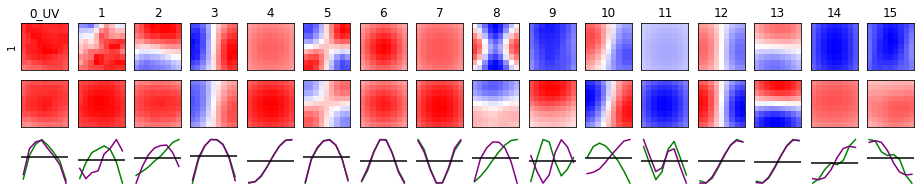

In [22]:
eigvecs=np.load('../data/eigvecs_3d.npy') 
print (eigvecs.shape)
#show the first 16 PCA kernels
temptitle=1
Vis_conv3d_0(np.transpose(eigvecs[:16],axes=(0,4,1,2,3)),temptitle)

In [23]:
eigvecs_tensor=torch.from_numpy(np.transpose(eigvecs,axes=(0,4,1,2,3))).float()
print (eigvecs_tensor.shape)

torch.Size([1296, 2, 8, 9, 9])


##  <font color='red'>ModelSE3d1_Exp_pca, conv 3d</font> 

In [24]:
class ModelSE3d1_Exp_pca(nn.Module):
    def __init__(self,eigvecs_tensor,numofbasis=8):
        super().__init__()
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #size of feature
        self.numofneuron=96 #number of neurons
        self.numofbasis=numofbasis #number of basis functions used
        #self.dct_basis_tensor=dct_basis_tensor[:self.numofbasis] #dct basis functions, shape (81,9,9)
        self.register_buffer('basis', eigvecs_tensor[:self.numofbasis])
        #
        #coefficients of those basis function for 16 spatial kernels
        self.conv1_ss=nn.Parameter(torch.zeros(self.numoffea,self.numofbasis))
        std=1. / np.sqrt(self.numofbasis)
        self.conv1_ss.data.uniform_(-std*1, std*1) 
        self.conv1_ss_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_ss_bias.data.uniform_(-std, std)
        #
        #self.conv1=nn.Conv3d(2,self.numoffea,kernel_size=(8,9,9),stride=1)#16,20*20
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)

    def forward(self, x):
        #encoded = F.relu(self.conv1(x)) #16,20*20
        encoded = F.conv3d(x,\
        torch.matmul(self.conv1_ss,self.basis.view(self.numofbasis,-1)).view(self.numoffea,2,8,9,9),\
                           bias=self.conv1_ss_bias,stride=1,padding=(0,0,0))
        encoded = F.relu(encoded)
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        return encoded
def Ploss_L2L1_SE(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempB, tempN =x.size()
    Ploss = F.poisson_nll_loss(recon_x, x,log_input=False, reduction='sum')
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.norm(2) # temp.weight.norm(2)
    L2loss=alpha*l2temp
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.weight.norm(1)
    L1loss=beta*l1temp
    return (Ploss+L2loss+L1loss)/(tempB* tempN)

(8, 2, 8, 9, 9)
(16, 8)


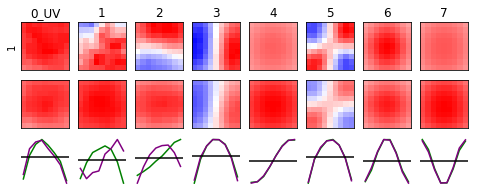

In [25]:
tempmodel= ModelSE3d1_Exp_pca(eigvecs_tensor,8)
temp=tempmodel.basis.cpu().data.numpy()
print (temp.shape)
temptitle=1
Vis_conv3d_0(temp,temptitle)
#
temp=tempmodel.conv1_ss.cpu().data.numpy()
print (temp.shape)

### numofbasis=1

In [32]:
numofbasis=1
EPOCH=100
LR = 2e-4
alphas=[0.0,1e2,1e3,1e4,1e5] # [0.0,1e0,1e1,1e2,1e3]
betas =[0.0, 1, 4, 16, 64] # [0.0,1/64,1/16,1/4,1]
modeltrainloss=[]
modelvalloss=[]
for ii in range(len(alphas)):
    for jj in range(len(betas)):
        modelname=str(ii*len(betas)+jj+1)
        torch.manual_seed(1)    # reproducible
        torch.cuda.manual_seed(1)
        tempmodel = ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE,valdata=val_loader,\
                             alpha=alphas[ii],beta=betas[jj],alpha2=None,earlystop=True,verbose=True)
        modeltrainloss.append(temp)
        torch.save(tempmodel.state_dict(),\
                       './out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_'+modelname+'.pth')
        temp=model_val(tempmodel,val_loader,1,device_cpu,loss_mse)
        modelvalloss.append(temp)
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

2020-12-11 20:14:27.461887
Model:  ModelSE3d1_Exp_pca |Epoch:  0 | train loss: 1.0513
Model:  ModelSE3d1_Exp_pca |Epoch:  1 | train loss: 0.4406
Model:  ModelSE3d1_Exp_pca |Epoch:  2 | train loss: 0.4025
Model:  ModelSE3d1_Exp_pca |Epoch:  3 | train loss: 0.4005
Model:  ModelSE3d1_Exp_pca |Epoch:  4 | train loss: 0.3998
Model:  ModelSE3d1_Exp_pca |Epoch:  5 | train loss: 0.3995
Model:  ModelSE3d1_Exp_pca |Epoch:  6 | train loss: 0.3992
Model:  ModelSE3d1_Exp_pca |Epoch:  7 | train loss: 0.3989
Model:  ModelSE3d1_Exp_pca |Epoch:  8 | train loss: 0.3986
Model:  ModelSE3d1_Exp_pca |Epoch:  9 | train loss: 0.3983
Model:  ModelSE3d1_Exp_pca |Epoch:  10 | train loss: 0.3979
Model:  ModelSE3d1_Exp_pca |Epoch:  11 | train loss: 0.3975
Model:  ModelSE3d1_Exp_pca |Epoch:  12 | train loss: 0.3971
Model:  ModelSE3d1_Exp_pca |Epoch:  13 | train loss: 0.3966
Model:  ModelSE3d1_Exp_pca |Epoch:  14 | train loss: 0.3962
Model:  ModelSE3d1_Exp_pca |Epoch:  15 | train loss: 0.3957
Model:  ModelSE3d1_Exp_

In [33]:
temp2=np.reshape(np.array(modelvalloss),(5,5))
print (temp2)
print (np.max(temp2))

[[0.20789044 0.2284007  0.23125438 0.23030697 0.23073732]
 [0.21398497 0.22879983 0.23150352 0.23090487 0.23122931]
 [0.21591398 0.22883074 0.23171379 0.23163773 0.23154066]
 [0.21604374 0.22880457 0.23170018 0.23207209 0.22987394]
 [0.21605456 0.22880647 0.23168402 0.2318947  0.23127574]]
0.23207208858665915


### numofbasis=2

In [34]:
numofbasis=2
EPOCH=100
LR = 2e-4
alphas=[0.0,1e2,1e3,1e4,1e5] # [0.0,1e0,1e1,1e2,1e3]
betas =[0.0, 1, 4, 16, 64] # [0.0,1/64,1/16,1/4,1]
modeltrainloss=[]
modelvalloss=[]
for ii in range(len(alphas)):
    for jj in range(len(betas)):
        modelname=str(ii*len(betas)+jj+1)
        torch.manual_seed(1)    # reproducible
        torch.cuda.manual_seed(1)
        tempmodel = ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE,valdata=val_loader,\
                             alpha=alphas[ii],beta=betas[jj],alpha2=None,earlystop=True,verbose=True)
        modeltrainloss.append(temp)
        torch.save(tempmodel.state_dict(),\
                       './out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_'+modelname+'.pth')
        temp=model_val(tempmodel,val_loader,1,device_cpu,loss_mse)
        modelvalloss.append(temp)
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

2020-12-11 20:19:38.874319
Model:  ModelSE3d1_Exp_pca |Epoch:  0 | train loss: 1.0306
Model:  ModelSE3d1_Exp_pca |Epoch:  1 | train loss: 0.4355
Model:  ModelSE3d1_Exp_pca |Epoch:  2 | train loss: 0.4051
Model:  ModelSE3d1_Exp_pca |Epoch:  3 | train loss: 0.4013
Model:  ModelSE3d1_Exp_pca |Epoch:  4 | train loss: 0.4001
Model:  ModelSE3d1_Exp_pca |Epoch:  5 | train loss: 0.3996
Model:  ModelSE3d1_Exp_pca |Epoch:  6 | train loss: 0.3989
Model:  ModelSE3d1_Exp_pca |Epoch:  7 | train loss: 0.3983
Model:  ModelSE3d1_Exp_pca |Epoch:  8 | train loss: 0.3977
Model:  ModelSE3d1_Exp_pca |Epoch:  9 | train loss: 0.3971
Model:  ModelSE3d1_Exp_pca |Epoch:  10 | train loss: 0.3965
Model:  ModelSE3d1_Exp_pca |Epoch:  11 | train loss: 0.3959
Model:  ModelSE3d1_Exp_pca |Epoch:  12 | train loss: 0.3952
Model:  ModelSE3d1_Exp_pca |Epoch:  13 | train loss: 0.3946
Model:  ModelSE3d1_Exp_pca |Epoch:  14 | train loss: 0.3940
Model:  ModelSE3d1_Exp_pca |Epoch:  15 | train loss: 0.3933
Model:  ModelSE3d1_Exp_

In [35]:
temp2=np.reshape(np.array(modelvalloss),(5,5))
print (temp2)
print (np.max(temp2))

[[0.21090103 0.23020736 0.23276855 0.23279415 0.22409106]
 [0.21865649 0.23054467 0.23264609 0.23262657 0.22498596]
 [0.22087155 0.23036117 0.23290539 0.23285794 0.22489312]
 [0.22100386 0.23032637 0.23289083 0.2332731  0.22495579]
 [0.22101447 0.23035501 0.23296517 0.23324561 0.22474651]]
0.23327310096776685


### numofbasis=4

In [36]:
numofbasis=4
EPOCH=100
LR = 2e-4
alphas=[0.0,1e2,1e3,1e4,1e5] # [0.0,1e0,1e1,1e2,1e3]
betas =[0.0, 1, 4, 16, 64] # [0.0,1/64,1/16,1/4,1]
modeltrainloss=[]
modelvalloss=[]
for ii in range(len(alphas)):
    for jj in range(len(betas)):
        modelname=str(ii*len(betas)+jj+1)
        torch.manual_seed(1)    # reproducible
        torch.cuda.manual_seed(1)
        tempmodel = ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE,valdata=val_loader,\
                             alpha=alphas[ii],beta=betas[jj],alpha2=None,earlystop=True,verbose=True)
        modeltrainloss.append(temp)
        torch.save(tempmodel.state_dict(),\
                       './out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_'+modelname+'.pth')
        temp=model_val(tempmodel,val_loader,1,device_cpu,loss_mse)
        modelvalloss.append(temp)
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

2020-12-11 20:23:23.240387
Model:  ModelSE3d1_Exp_pca |Epoch:  0 | train loss: 1.0217
Model:  ModelSE3d1_Exp_pca |Epoch:  1 | train loss: 0.4189
Model:  ModelSE3d1_Exp_pca |Epoch:  2 | train loss: 0.4087
Model:  ModelSE3d1_Exp_pca |Epoch:  3 | train loss: 0.4015
Model:  ModelSE3d1_Exp_pca |Epoch:  4 | train loss: 0.4011
Model:  ModelSE3d1_Exp_pca |Epoch:  5 | train loss: 0.4002
Model:  ModelSE3d1_Exp_pca |Epoch:  6 | train loss: 0.3994
Model:  ModelSE3d1_Exp_pca |Epoch:  7 | train loss: 0.3987
Model:  ModelSE3d1_Exp_pca |Epoch:  8 | train loss: 0.3979
Model:  ModelSE3d1_Exp_pca |Epoch:  9 | train loss: 0.3972
Model:  ModelSE3d1_Exp_pca |Epoch:  10 | train loss: 0.3964
Model:  ModelSE3d1_Exp_pca |Epoch:  11 | train loss: 0.3956
Model:  ModelSE3d1_Exp_pca |Epoch:  12 | train loss: 0.3948
Model:  ModelSE3d1_Exp_pca |Epoch:  13 | train loss: 0.3940
Model:  ModelSE3d1_Exp_pca |Epoch:  14 | train loss: 0.3932
Model:  ModelSE3d1_Exp_pca |Epoch:  15 | train loss: 0.3923
Model:  ModelSE3d1_Exp_

In [37]:
temp2=np.reshape(np.array(modelvalloss),(5,5))
print (temp2)
print (np.max(temp2))

[[0.20171077 0.22088773 0.20989897 0.1830284  0.10049205]
 [0.20965945 0.22309706 0.21033639 0.18299967 0.09032453]
 [0.21421054 0.22617548 0.21828673 0.16866366 0.08347741]
 [0.21434363 0.226065   0.21894555 0.19887838 0.08566561]
 [0.21434081 0.22608075 0.21896113 0.1990665  0.08502109]]
0.2261754839631871


### numofbasis=8

In [41]:
numofbasis=8
EPOCH=100
LR = 2e-4
alphas=[0.0,1e2,1e3,1e4,1e5] # [0.0,1e0,1e1,1e2,1e3]
betas =[0.0, 1/16, 1/4, 1, 4] # [0.0,1/64,1/16,1/4,1]
modeltrainloss=[]
modelvalloss=[]
for ii in range(len(alphas)):
    for jj in range(len(betas)):
        modelname=str(ii*len(betas)+jj+1)
        torch.manual_seed(1)    # reproducible
        torch.cuda.manual_seed(1)
        tempmodel = ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE,valdata=val_loader,\
                             alpha=alphas[ii],beta=betas[jj],alpha2=None,earlystop=True,verbose=True)
        modeltrainloss.append(temp)
        torch.save(tempmodel.state_dict(),\
                       './out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_'+modelname+'.pth')
        temp=model_val(tempmodel,val_loader,1,device_cpu,loss_mse)
        modelvalloss.append(temp)
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

2020-12-11 20:34:14.568901
Model:  ModelSE3d1_Exp_pca |Epoch:  0 | train loss: 1.0215
Model:  ModelSE3d1_Exp_pca |Epoch:  1 | train loss: 0.4223
Model:  ModelSE3d1_Exp_pca |Epoch:  2 | train loss: 0.4030
Model:  ModelSE3d1_Exp_pca |Epoch:  3 | train loss: 0.3979
Model:  ModelSE3d1_Exp_pca |Epoch:  4 | train loss: 0.3968
Model:  ModelSE3d1_Exp_pca |Epoch:  5 | train loss: 0.3954
Model:  ModelSE3d1_Exp_pca |Epoch:  6 | train loss: 0.3942
Model:  ModelSE3d1_Exp_pca |Epoch:  7 | train loss: 0.3929
Model:  ModelSE3d1_Exp_pca |Epoch:  8 | train loss: 0.3916
Model:  ModelSE3d1_Exp_pca |Epoch:  9 | train loss: 0.3904
Model:  ModelSE3d1_Exp_pca |Epoch:  10 | train loss: 0.3891
Model:  ModelSE3d1_Exp_pca |Epoch:  11 | train loss: 0.3878
Model:  ModelSE3d1_Exp_pca |Epoch:  12 | train loss: 0.3866
Model:  ModelSE3d1_Exp_pca |Epoch:  13 | train loss: 0.3853
Model:  ModelSE3d1_Exp_pca |Epoch:  14 | train loss: 0.3840
Model:  ModelSE3d1_Exp_pca |Epoch:  15 | train loss: 0.3828
Model:  ModelSE3d1_Exp_

In [42]:
temp2=np.reshape(np.array(modelvalloss),(5,5))
print (temp2)
print (np.max(temp2))

[[0.23547118 0.23842662 0.24355901 0.23698422 0.22609052]
 [0.24159552 0.25534231 0.25075328 0.23643029 0.2291966 ]
 [0.24833714 0.24013885 0.23286573 0.23235447 0.23271569]
 [0.24044671 0.23661775 0.23104004 0.23193934 0.23329877]
 [0.23972315 0.23625712 0.230868   0.23190299 0.23332671]]
0.2553423087615411


(8, 2, 8, 9, 9)
(16, 8)


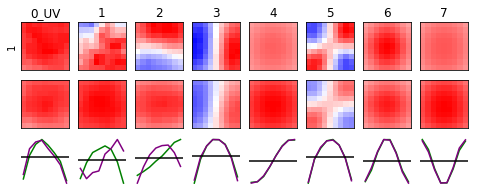

In [40]:
tempmodel= ModelSE3d1_Exp_pca(eigvecs_tensor,8)
tempmodel.load_state_dict(torch.load('./out/20200429_v5_ModelSE3d1_Exp_pca_8basis_Ploss_'+str(11)+'.pth'))
temp=tempmodel.basis.cpu().data.numpy()
print (temp.shape)
temptitle=1
Vis_conv3d_0(temp,temptitle)
#
temp=tempmodel.conv1_ss.cpu().data.numpy()
print (temp.shape)

### numofbasis=16

In [43]:
numofbasis=16
EPOCH=100
LR = 2e-4
alphas=[0.0,1e0,1e1,1e2,1e3] # [0.0,1e0,1e1,1e2,1e3]
betas =[0.0,1/64,1/16,1/4,1] # [0.0,1/64,1/16,1/4,1]
modeltrainloss=[]
modelvalloss=[]
for ii in range(len(alphas)):
    for jj in range(len(betas)):
        modelname=str(ii*len(betas)+jj+1)
        torch.manual_seed(1)    # reproducible
        torch.cuda.manual_seed(1)
        tempmodel = ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE,valdata=val_loader,\
                             alpha=alphas[ii],beta=betas[jj],alpha2=None,earlystop=True,verbose=True)
        modeltrainloss.append(temp)
        torch.save(tempmodel.state_dict(),\
                       './out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_'+modelname+'.pth')
        temp=model_val(tempmodel,val_loader,1,device_cpu,loss_mse)
        modelvalloss.append(temp)
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

2020-12-11 20:41:56.249037
Model:  ModelSE3d1_Exp_pca |Epoch:  0 | train loss: 1.0176
Model:  ModelSE3d1_Exp_pca |Epoch:  1 | train loss: 0.4202
Model:  ModelSE3d1_Exp_pca |Epoch:  2 | train loss: 0.4035
Model:  ModelSE3d1_Exp_pca |Epoch:  3 | train loss: 0.3979
Model:  ModelSE3d1_Exp_pca |Epoch:  4 | train loss: 0.3968
Model:  ModelSE3d1_Exp_pca |Epoch:  5 | train loss: 0.3951
Model:  ModelSE3d1_Exp_pca |Epoch:  6 | train loss: 0.3936
Model:  ModelSE3d1_Exp_pca |Epoch:  7 | train loss: 0.3920
Model:  ModelSE3d1_Exp_pca |Epoch:  8 | train loss: 0.3904
Model:  ModelSE3d1_Exp_pca |Epoch:  9 | train loss: 0.3889
Model:  ModelSE3d1_Exp_pca |Epoch:  10 | train loss: 0.3873
Model:  ModelSE3d1_Exp_pca |Epoch:  11 | train loss: 0.3858
Model:  ModelSE3d1_Exp_pca |Epoch:  12 | train loss: 0.3843
Model:  ModelSE3d1_Exp_pca |Epoch:  13 | train loss: 0.3828
Model:  ModelSE3d1_Exp_pca |Epoch:  14 | train loss: 0.3813
Model:  ModelSE3d1_Exp_pca |Epoch:  15 | train loss: 0.3799
Model:  ModelSE3d1_Exp_

In [44]:
temp2=np.reshape(np.array(modelvalloss),(5,5))
print (temp2)
print (np.max(temp2))

[[0.23989892 0.24099016 0.24490039 0.25459544 0.23967362]
 [0.23997728 0.24107776 0.24479006 0.25459733 0.23987776]
 [0.24035659 0.24156941 0.24558914 0.25586792 0.24036668]
 [0.24662043 0.24927241 0.26176982 0.26497281 0.25136156]
 [0.24519435 0.24461416 0.24265878 0.23570349 0.23311131]]
0.26497281141386086


### numofbasis=32

In [45]:
numofbasis=32
EPOCH=100
LR = 2e-4
alphas=[0.0,1e0,1e1,1e2,1e3] # [0.0,1e0,1e1,1e2,1e3]
betas =[0.0,1/64,1/16,1/4,1] # [0.0,1/64,1/16,1/4,1]
modeltrainloss=[]
modelvalloss=[]
for ii in range(len(alphas)):
    for jj in range(len(betas)):
        modelname=str(ii*len(betas)+jj+1)
        torch.manual_seed(1)    # reproducible
        torch.cuda.manual_seed(1)
        tempmodel = ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE,valdata=val_loader,\
                             alpha=alphas[ii],beta=betas[jj],alpha2=None,earlystop=True,verbose=True)
        modeltrainloss.append(temp)
        torch.save(tempmodel.state_dict(),\
                       './out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_'+modelname+'.pth')
        temp=model_val(tempmodel,val_loader,1,device_cpu,loss_mse)
        modelvalloss.append(temp)
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

2020-12-11 20:48:31.418153
Model:  ModelSE3d1_Exp_pca |Epoch:  0 | train loss: 1.0140
Model:  ModelSE3d1_Exp_pca |Epoch:  1 | train loss: 0.4124
Model:  ModelSE3d1_Exp_pca |Epoch:  2 | train loss: 0.4074
Model:  ModelSE3d1_Exp_pca |Epoch:  3 | train loss: 0.3997
Model:  ModelSE3d1_Exp_pca |Epoch:  4 | train loss: 0.3977
Model:  ModelSE3d1_Exp_pca |Epoch:  5 | train loss: 0.3963
Model:  ModelSE3d1_Exp_pca |Epoch:  6 | train loss: 0.3946
Model:  ModelSE3d1_Exp_pca |Epoch:  7 | train loss: 0.3928
Model:  ModelSE3d1_Exp_pca |Epoch:  8 | train loss: 0.3910
Model:  ModelSE3d1_Exp_pca |Epoch:  9 | train loss: 0.3892
Model:  ModelSE3d1_Exp_pca |Epoch:  10 | train loss: 0.3873
Model:  ModelSE3d1_Exp_pca |Epoch:  11 | train loss: 0.3854
Model:  ModelSE3d1_Exp_pca |Epoch:  12 | train loss: 0.3834
Model:  ModelSE3d1_Exp_pca |Epoch:  13 | train loss: 0.3815
Model:  ModelSE3d1_Exp_pca |Epoch:  14 | train loss: 0.3795
Model:  ModelSE3d1_Exp_pca |Epoch:  15 | train loss: 0.3774
Model:  ModelSE3d1_Exp_

In [46]:
temp2=np.reshape(np.array(modelvalloss),(5,5))
print (temp2)
print (np.max(temp2))

[[0.2526577  0.25413467 0.25944414 0.25926854 0.23374605]
 [0.25274516 0.25422495 0.25956699 0.25926854 0.2336866 ]
 [0.25273905 0.25437852 0.26024165 0.25964463 0.23400605]
 [0.25887319 0.26125578 0.27202417 0.27944581 0.23841059]
 [0.24119939 0.2416943  0.23958695 0.23639822 0.23305082]]
0.27944581445254796


### numofbasis=64

In [47]:
numofbasis=64
EPOCH=100
LR = 2e-4
alphas=[0.0,1e0,1e1,1e2,1e3] # [0.0,1e0,1e1,1e2,1e3]
betas =[0.0,1/64,1/16,1/4,1] # [0.0,1/64,1/16,1/4,1]
modeltrainloss=[]
modelvalloss=[]
for ii in range(len(alphas)):
    for jj in range(len(betas)):
        modelname=str(ii*len(betas)+jj+1)
        torch.manual_seed(1)    # reproducible
        torch.cuda.manual_seed(1)
        tempmodel = ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE,valdata=val_loader,\
                             alpha=alphas[ii],beta=betas[jj],alpha2=None,earlystop=True,verbose=True)
        modeltrainloss.append(temp)
        torch.save(tempmodel.state_dict(),\
                       './out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_'+modelname+'.pth')
        temp=model_val(tempmodel,val_loader,1,device_cpu,loss_mse)
        modelvalloss.append(temp)
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

2020-12-11 20:55:57.504932
Model:  ModelSE3d1_Exp_pca |Epoch:  0 | train loss: 1.0129
Model:  ModelSE3d1_Exp_pca |Epoch:  1 | train loss: 0.4096
Model:  ModelSE3d1_Exp_pca |Epoch:  2 | train loss: 0.4055
Model:  ModelSE3d1_Exp_pca |Epoch:  3 | train loss: 0.3974
Model:  ModelSE3d1_Exp_pca |Epoch:  4 | train loss: 0.3962
Model:  ModelSE3d1_Exp_pca |Epoch:  5 | train loss: 0.3949
Model:  ModelSE3d1_Exp_pca |Epoch:  6 | train loss: 0.3933
Model:  ModelSE3d1_Exp_pca |Epoch:  7 | train loss: 0.3917
Model:  ModelSE3d1_Exp_pca |Epoch:  8 | train loss: 0.3900
Model:  ModelSE3d1_Exp_pca |Epoch:  9 | train loss: 0.3882
Model:  ModelSE3d1_Exp_pca |Epoch:  10 | train loss: 0.3864
Model:  ModelSE3d1_Exp_pca |Epoch:  11 | train loss: 0.3845
Model:  ModelSE3d1_Exp_pca |Epoch:  12 | train loss: 0.3825
Model:  ModelSE3d1_Exp_pca |Epoch:  13 | train loss: 0.3804
Model:  ModelSE3d1_Exp_pca |Epoch:  14 | train loss: 0.3783
Model:  ModelSE3d1_Exp_pca |Epoch:  15 | train loss: 0.3761
Model:  ModelSE3d1_Exp_

In [48]:
temp2=np.reshape(np.array(modelvalloss),(5,5))
print (temp2)
print (np.max(temp2))

[[0.25410465 0.25555795 0.26108281 0.26514337 0.2219509 ]
 [0.25432119 0.25578522 0.26129992 0.26539079 0.22202634]
 [0.25510537 0.2577298  0.26263295 0.26711041 0.22180138]
 [0.27184555 0.27395455 0.28305603 0.2969611  0.22003884]
 [0.23471351 0.23642888 0.23572133 0.23433366 0.21850709]]
0.29696109689702116


Overall pearson correlation coefficient:  0.489824875345939  and p-value:  4.042131101931739e-248


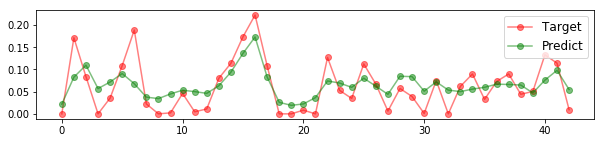

In [61]:
#test model
numofbasis=64
tempmodel=ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
tempmodel.load_state_dict(torch.load\
                    ('./out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_19.pth'))
tempmodel=tempmodel.to(device_cpu)
_=model_test(tempmodel,test_loader,device_cpu,use_pad0_sti=False)
torch.cuda.empty_cache()

### numofbasis=128

In [49]:
numofbasis=128
EPOCH=100
LR = 2e-4
alphas=[0.0,1e0,1e1,1e2,1e3] # [0.0,1e0,1e1,1e2,1e3]
betas =[0.0,1/64,1/16,1/4,1] # [0.0,1/64,1/16,1/4,1]
modeltrainloss=[]
modelvalloss=[]
for ii in range(len(alphas)):
    for jj in range(len(betas)):
        modelname=str(ii*len(betas)+jj+1)
        torch.manual_seed(1)    # reproducible
        torch.cuda.manual_seed(1)
        tempmodel = ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE,valdata=val_loader,\
                             alpha=alphas[ii],beta=betas[jj],alpha2=None,earlystop=True,verbose=True)
        modeltrainloss.append(temp)
        torch.save(tempmodel.state_dict(),\
                       './out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_'+modelname+'.pth')
        temp=model_val(tempmodel,val_loader,1,device_cpu,loss_mse)
        modelvalloss.append(temp)
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

2020-12-11 21:00:48.102721
Model:  ModelSE3d1_Exp_pca |Epoch:  0 | train loss: 1.0111
Model:  ModelSE3d1_Exp_pca |Epoch:  1 | train loss: 0.4136
Model:  ModelSE3d1_Exp_pca |Epoch:  2 | train loss: 0.4055
Model:  ModelSE3d1_Exp_pca |Epoch:  3 | train loss: 0.3978
Model:  ModelSE3d1_Exp_pca |Epoch:  4 | train loss: 0.3971
Model:  ModelSE3d1_Exp_pca |Epoch:  5 | train loss: 0.3954
Model:  ModelSE3d1_Exp_pca |Epoch:  6 | train loss: 0.3937
Model:  ModelSE3d1_Exp_pca |Epoch:  7 | train loss: 0.3920
Model:  ModelSE3d1_Exp_pca |Epoch:  8 | train loss: 0.3902
Model:  ModelSE3d1_Exp_pca |Epoch:  9 | train loss: 0.3882
Model:  ModelSE3d1_Exp_pca |Epoch:  10 | train loss: 0.3862
Model:  ModelSE3d1_Exp_pca |Epoch:  11 | train loss: 0.3840
Model:  ModelSE3d1_Exp_pca |Epoch:  12 | train loss: 0.3817
Model:  ModelSE3d1_Exp_pca |Epoch:  13 | train loss: 0.3793
Model:  ModelSE3d1_Exp_pca |Epoch:  14 | train loss: 0.3768
Model:  ModelSE3d1_Exp_pca |Epoch:  15 | train loss: 0.3741
Model:  ModelSE3d1_Exp_

In [50]:
temp2=np.reshape(np.array(modelvalloss),(5,5))
print (temp2)
print (np.max(temp2))

[[0.25493814 0.25788389 0.26377578 0.27433503 0.2425145 ]
 [0.25527839 0.25821187 0.26412026 0.27470616 0.24220393]
 [0.25664658 0.25970588 0.26610596 0.2767714  0.24238323]
 [0.28201213 0.28497808 0.29389969 0.31417372 0.24107224]
 [0.23160758 0.23162565 0.23169072 0.23188459 0.23213955]]
0.31417371669302063


(16, 2, 8, 9, 9)


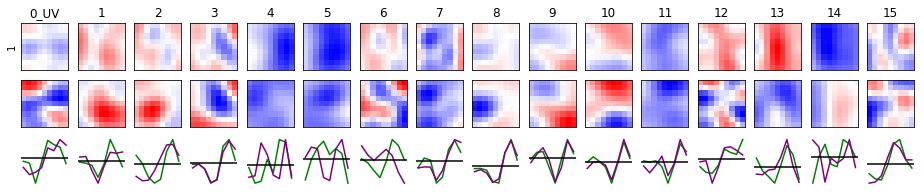

In [57]:
#RFs
numofbasis=128
tempmodel=ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
tempmodel.load_state_dict(torch.load\
                    ('./out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_19.pth'))
conv1_ss=torch.matmul(tempmodel.conv1_ss,\
                tempmodel.basis.view(tempmodel.numofbasis,-1)).view(tempmodel.numoffea,2,8,9,9).cpu().data.numpy()
print (conv1_ss.shape)
temptitle=1
Vis_conv3d_0(conv1_ss,temptitle)

Overall pearson correlation coefficient:  0.5032224478988567  and p-value:  5.931702695465042e-264


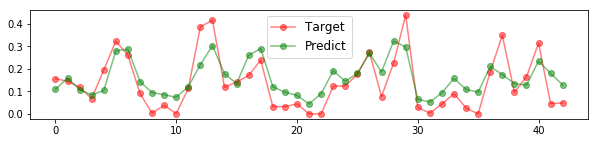

In [60]:
#test model
numofbasis=128
tempmodel=ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
tempmodel.load_state_dict(torch.load\
                    ('./out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_19.pth'))
tempmodel=tempmodel.to(device_cpu)
_=model_test(tempmodel,test_loader,device_cpu,use_pad0_sti=False)
torch.cuda.empty_cache()

### numofbasis=256

In [51]:
numofbasis=256
EPOCH=100
LR = 2e-4
alphas=[0.0,1e0,1e1,1e2,1e3] # [0.0,1e0,1e1,1e2,1e3]
betas =[0.0,1/64,1/16,1/4,1] # [0.0,1/64,1/16,1/4,1]
modeltrainloss=[]
modelvalloss=[]
for ii in range(len(alphas)):
    for jj in range(len(betas)):
        modelname=str(ii*len(betas)+jj+1)
        torch.manual_seed(1)    # reproducible
        torch.cuda.manual_seed(1)
        tempmodel = ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE,valdata=val_loader,\
                             alpha=alphas[ii],beta=betas[jj],alpha2=None,earlystop=True,verbose=True)
        modeltrainloss.append(temp)
        torch.save(tempmodel.state_dict(),\
                       './out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_'+modelname+'.pth')
        temp=model_val(tempmodel,val_loader,1,device_cpu,loss_mse)
        modelvalloss.append(temp)
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

2020-12-11 21:10:52.072428
Model:  ModelSE3d1_Exp_pca |Epoch:  0 | train loss: 1.0121
Model:  ModelSE3d1_Exp_pca |Epoch:  1 | train loss: 0.4144
Model:  ModelSE3d1_Exp_pca |Epoch:  2 | train loss: 0.4049
Model:  ModelSE3d1_Exp_pca |Epoch:  3 | train loss: 0.3979
Model:  ModelSE3d1_Exp_pca |Epoch:  4 | train loss: 0.3973
Model:  ModelSE3d1_Exp_pca |Epoch:  5 | train loss: 0.3956
Model:  ModelSE3d1_Exp_pca |Epoch:  6 | train loss: 0.3941
Model:  ModelSE3d1_Exp_pca |Epoch:  7 | train loss: 0.3924
Model:  ModelSE3d1_Exp_pca |Epoch:  8 | train loss: 0.3906
Model:  ModelSE3d1_Exp_pca |Epoch:  9 | train loss: 0.3887
Model:  ModelSE3d1_Exp_pca |Epoch:  10 | train loss: 0.3866
Model:  ModelSE3d1_Exp_pca |Epoch:  11 | train loss: 0.3845
Model:  ModelSE3d1_Exp_pca |Epoch:  12 | train loss: 0.3821
Model:  ModelSE3d1_Exp_pca |Epoch:  13 | train loss: 0.3796
Model:  ModelSE3d1_Exp_pca |Epoch:  14 | train loss: 0.3769
Model:  ModelSE3d1_Exp_pca |Epoch:  15 | train loss: 0.3741
Model:  ModelSE3d1_Exp_

In [52]:
temp2=np.reshape(np.array(modelvalloss),(5,5))
print (temp2)
print (np.max(temp2))

[[0.2509618  0.25167319 0.25946636 0.27030369 0.23312032]
 [0.25146354 0.25219128 0.25995342 0.27078693 0.23309092]
 [0.25347195 0.25673094 0.2624926  0.27300775 0.23305678]
 [0.28588855 0.28920468 0.29660133 0.30998401 0.23308724]
 [0.23154589 0.23156191 0.23163835 0.2318545  0.23202878]]
0.3099840126288094


### numofbasis=512

In [53]:
numofbasis=512
EPOCH=100
LR = 2e-4
alphas=[0.0,1e0,1e1,1e2,1e3] # [0.0,1e0,1e1,1e2,1e3]
betas =[0.0,1/64,1/16,1/4,1] # [0.0,1/64,1/16,1/4,1]
modeltrainloss=[]
modelvalloss=[]
for ii in range(len(alphas)):
    for jj in range(len(betas)):
        modelname=str(ii*len(betas)+jj+1)
        torch.manual_seed(1)    # reproducible
        torch.cuda.manual_seed(1)
        tempmodel = ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE,valdata=val_loader,\
                             alpha=alphas[ii],beta=betas[jj],alpha2=None,earlystop=True,verbose=True)
        modeltrainloss.append(temp)
        torch.save(tempmodel.state_dict(),\
                       './out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_'+modelname+'.pth')
        temp=model_val(tempmodel,val_loader,1,device_cpu,loss_mse)
        modelvalloss.append(temp)
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

2020-12-11 21:16:25.017220
Model:  ModelSE3d1_Exp_pca |Epoch:  0 | train loss: 1.0127
Model:  ModelSE3d1_Exp_pca |Epoch:  1 | train loss: 0.4129
Model:  ModelSE3d1_Exp_pca |Epoch:  2 | train loss: 0.4032
Model:  ModelSE3d1_Exp_pca |Epoch:  3 | train loss: 0.3968
Model:  ModelSE3d1_Exp_pca |Epoch:  4 | train loss: 0.3962
Model:  ModelSE3d1_Exp_pca |Epoch:  5 | train loss: 0.3945
Model:  ModelSE3d1_Exp_pca |Epoch:  6 | train loss: 0.3930
Model:  ModelSE3d1_Exp_pca |Epoch:  7 | train loss: 0.3913
Model:  ModelSE3d1_Exp_pca |Epoch:  8 | train loss: 0.3895
Model:  ModelSE3d1_Exp_pca |Epoch:  9 | train loss: 0.3876
Model:  ModelSE3d1_Exp_pca |Epoch:  10 | train loss: 0.3855
Model:  ModelSE3d1_Exp_pca |Epoch:  11 | train loss: 0.3832
Model:  ModelSE3d1_Exp_pca |Epoch:  12 | train loss: 0.3808
Model:  ModelSE3d1_Exp_pca |Epoch:  13 | train loss: 0.3782
Model:  ModelSE3d1_Exp_pca |Epoch:  14 | train loss: 0.3754
Model:  ModelSE3d1_Exp_pca |Epoch:  15 | train loss: 0.3723
Model:  ModelSE3d1_Exp_

In [54]:
temp2=np.reshape(np.array(modelvalloss),(5,5))
print (temp2)
print (np.max(temp2))

[[0.23842428 0.23957019 0.24644978 0.25187047 0.23443545]
 [0.23903954 0.24019347 0.24711094 0.25240453 0.2345278 ]
 [0.2418198  0.2431029  0.25046403 0.25551545 0.23466546]
 [0.28005105 0.2823699  0.29107107 0.29533581 0.23620695]
 [0.23159057 0.2315806  0.2315966  0.23190837 0.23240048]]
0.2953358053132706


### numofbasis=1024

In [55]:
numofbasis=1024
EPOCH=100
LR = 2e-4
alphas=[0.0,1e0,1e1,1e2,1e3] # [0.0,1e0,1e1,1e2,1e3]
betas =[0.0,1/64,1/16,1/4,1] # [0.0,1/64,1/16,1/4,1]
modeltrainloss=[]
modelvalloss=[]
for ii in range(len(alphas)):
    for jj in range(len(betas)):
        modelname=str(ii*len(betas)+jj+1)
        torch.manual_seed(1)    # reproducible
        torch.cuda.manual_seed(1)
        tempmodel = ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE,valdata=val_loader,\
                             alpha=alphas[ii],beta=betas[jj],alpha2=None,earlystop=True,verbose=True)
        modeltrainloss.append(temp)
        torch.save(tempmodel.state_dict(),\
                       './out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_'+modelname+'.pth')
        temp=model_val(tempmodel,val_loader,1,device_cpu,loss_mse)
        modelvalloss.append(temp)
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

2020-12-11 21:31:56.268007
Model:  ModelSE3d1_Exp_pca |Epoch:  0 | train loss: 1.0139
Model:  ModelSE3d1_Exp_pca |Epoch:  1 | train loss: 0.4143
Model:  ModelSE3d1_Exp_pca |Epoch:  2 | train loss: 0.4034
Model:  ModelSE3d1_Exp_pca |Epoch:  3 | train loss: 0.3968
Model:  ModelSE3d1_Exp_pca |Epoch:  4 | train loss: 0.3962
Model:  ModelSE3d1_Exp_pca |Epoch:  5 | train loss: 0.3944
Model:  ModelSE3d1_Exp_pca |Epoch:  6 | train loss: 0.3928
Model:  ModelSE3d1_Exp_pca |Epoch:  7 | train loss: 0.3911
Model:  ModelSE3d1_Exp_pca |Epoch:  8 | train loss: 0.3892
Model:  ModelSE3d1_Exp_pca |Epoch:  9 | train loss: 0.3872
Model:  ModelSE3d1_Exp_pca |Epoch:  10 | train loss: 0.3850
Model:  ModelSE3d1_Exp_pca |Epoch:  11 | train loss: 0.3826
Model:  ModelSE3d1_Exp_pca |Epoch:  12 | train loss: 0.3801
Model:  ModelSE3d1_Exp_pca |Epoch:  13 | train loss: 0.3773
Model:  ModelSE3d1_Exp_pca |Epoch:  14 | train loss: 0.3742
Model:  ModelSE3d1_Exp_pca |Epoch:  15 | train loss: 0.3708
Model:  ModelSE3d1_Exp_

In [56]:
temp2=np.reshape(np.array(modelvalloss),(5,5))
print (temp2)
print (np.max(temp2))

[[0.22790932 0.23005122 0.23352995 0.23339335 0.23042177]
 [0.22837157 0.22877402 0.23210027 0.23342136 0.23072668]
 [0.22858027 0.2311342  0.23487125 0.23399891 0.23100658]
 [0.26318977 0.26777432 0.27594072 0.2884838  0.23237397]
 [0.23152604 0.23153913 0.23160572 0.2318135  0.23206806]]
0.28848379506975635


### RFs and predictions

In [29]:
#save CCs
def model_test_save(model,data,device,use_pad0_sti=True):
    model=model.to(device)
    model=model.eval()
    (x,y)=data
    x=torch.from_numpy(x).float()
    b_x = x.to(device) 
    encoded = model(b_x)
    encoded_np=encoded.cpu().data.numpy()
    if use_pad0_sti==False: # do not use reponses of 0-padding stimulus, here 7 because we use 8 time lags
        encoded_np=encoded_np[7:,:]
        y=y[7:,:]
    testccs=np.zeros((encoded_np.shape[1]))
    for ii in range(encoded_np.shape[1]):
        testccs[ii],testpvalue=pearsonr(encoded_np[:,ii], y[:,ii])
    print (np.median(testccs))
    return testccs
#
numofbasis=128
seeds=np.arange(1,2)
for seed in seeds:
    tempmodel = ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
    tempmodel.load_state_dict(torch.load\
                    ('./out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_seed_'+str(seed)+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    CCs=model_test_save(tempmodel,test_loader,device_cpu,use_pad0_sti=False)
#print (CCs.shape)
#print (CCs)

0.4455592202200027


(16, 2, 8, 9, 9)


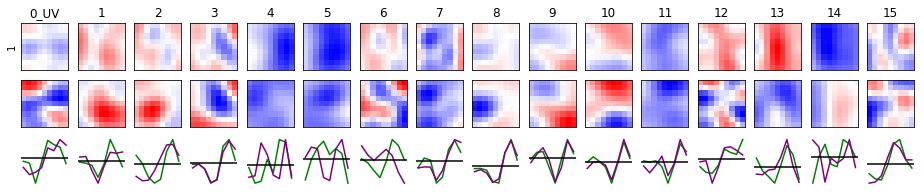

In [32]:
#RFs
numofbasis=128
tempmodel=ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
tempmodel.load_state_dict(torch.load\
                    ('./out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_seed_1.pth'))
conv1_ss=torch.matmul(tempmodel.conv1_ss,\
                tempmodel.basis.view(tempmodel.numofbasis,-1)).view(tempmodel.numoffea,2,8,9,9).cpu().data.numpy()
print (conv1_ss.shape)
temptitle=1
Vis_conv3d_0(conv1_ss,temptitle,save=False,\
    filename='out_result/20200429_ModelSE3d1_Exp_pca_dorsal_conv0_v5.svg')

In [26]:
#Use non-linear least squares to fit a 2d Gaussian function to conv0 and then measure the goodness of fit by r2
conv1_ss_s=[]
r2_s=[]
seeds=np.arange(1,11)
width,height=9,9
nt = 8 # time lag
ny = 9
nx = 9
dims = [nt, ny, nx]
for seed in seeds:
    numofbasis=128
    tempmodel=ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
    tempmodel.load_state_dict(torch.load\
                    ('./out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_seed_'+str(seed)+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    conv3d_0=torch.matmul(tempmodel.conv1_ss,\
                tempmodel.basis.view(tempmodel.numofbasis,-1)).view(tempmodel.numoffea,2,8,9,9).cpu().data.numpy()
    conv3d_0=np.reshape(conv3d_0,(-1,nt,ny,nx))
    for ii in range(len(conv3d_0)):
        [conv1_ss,_]=mySVD(conv3d_0[ii], dims)
        conv1_ss_s.append(conv1_ss)
conv1_ss_s=np.array(conv1_ss_s)
print (conv1_ss_s.shape)
conv1_ss_s=np.reshape(conv1_ss_s,(-1,width*height))
print (conv1_ss_s.shape)
#
for ii in range(len(conv1_ss_s)):
    fit_2dgaussian=Fit_2dGaussian(conv1_ss_s[ii],(width,height))
    fit_2dgaussian.fit()
    r2_s.append(fit_2dgaussian.cal_r2())
r2_s=np.array(r2_s)
print (np.median(r2_s))
print (np.mean(r2_s))

(320, 9, 9)
(320, 81)


/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.0
0.2979212146403048


(96, 2, 8, 28, 28)


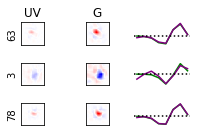

In [35]:
# save svd results of example neuronal RFs
nt = 8 # time lag
ny = 28
nx = 28
dims = [nt, ny, nx]
#
#visualize final layer of model
numofbasis=128
tempmodel=ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
tempmodel.load_state_dict(torch.load\
                    ('./out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_seed_1.pth'))
tempmodel=tempmodel.to(device_cpu)
RF_fl=vis_model_fl_3d(tempmodel,device_cpu,(1,2,8,28,28))
RF_fl_np=RF_fl.cpu().data.numpy() #output shape (50,2,28,28)
print (RF_fl_np.shape)
#nums_eg=np.arange(len(RF_fl_np))
#
#plot RFs
nums_eg=[63,3,78]  #np.arange(len(RF_fl_np))
nrows=len(nums_eg)
fig,axes = plt.subplots(nrows=nrows,ncols=3,figsize=(3,int(nrows/1.1)))
for ii in range(nrows):
    [sRF_UV, tRF_UV]=mySVD(RF_fl_np[nums_eg[ii],0], dims)
    [sRF_G, tRF_G]=mySVD(RF_fl_np[nums_eg[ii],1], dims)
    tempmax=np.max(np.abs([sRF_UV,sRF_G]))
    axes[ii,0].imshow(sRF_UV,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,0].set_xticks([])
    axes[ii,0].set_yticks([])
    axes[ii,0].set_ylabel('%d' %(nums_eg[ii]))
    axes[ii,1].imshow(sRF_G,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,1].set_xticks([])
    axes[ii,1].set_yticks([])
    axes[ii,2].plot(tRF_G,color='g',linestyle='-')
    axes[ii,2].plot(tRF_UV,color='purple',linestyle='-')
    axes[ii,2].axhline(y=0,color='k',linestyle=':')
    axes[ii,2].spines['left'].set_visible(False)
    axes[ii,2].spines['bottom'].set_visible(False)
    axes[ii,2].spines['right'].set_visible(False)
    axes[ii,2].spines['top'].set_visible(False)
    axes[ii,2].set_xticks([])
    axes[ii,2].set_yticks([])
axes[0,0].set_title('UV')
axes[0,1].set_title('G')
plt.tight_layout()

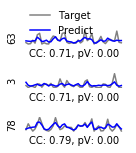

In [36]:
#plot prediction results for example neurons
numofbasis=128
tempmodel=ModelSE3d1_Exp_pca(eigvecs_tensor,numofbasis)
tempmodel.load_state_dict(torch.load\
                    ('./out/20200429_v5_ModelSE3d1_Exp_pca_'+str(numofbasis)+'basis_Ploss_seed_1.pth'))
tempmodel=tempmodel.to(device_cpu)
tempmodel=tempmodel.eval()
(x,y)=test_loader
x=torch.from_numpy(x).float()
b_x = x.to(device_cpu) 
with torch.no_grad():
    encoded = tempmodel(b_x)
encoded_np=encoded.cpu().data.numpy()
encoded_np=encoded_np[7:,:] #use_pad0_sti=False
y=y[7:,:] #use_pad0_sti=False
#
nums_eg=[63,3,78] 
nrows=len(nums_eg)
#nrows=encoded_np.shape[1]
testccs=np.zeros((nrows))
testpVs=np.zeros((nrows))
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(2,int(nrows/1.1)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,nums_eg[ii]], y[:,nums_eg[ii]])
    testccs[ii]=testcc
    testpVs[ii]=testpvalue
    axes[ii].plot(y[:,nums_eg[ii]],color='gray',linestyle='-',label='Target')
    axes[ii].plot(encoded_np[:,nums_eg[ii]],color='blue',linestyle='-',label='Predict')
    if ii == 0:
        axes[ii].legend(loc='best',frameon=False)
        #axes[ii].set_title('UVGnoise_30Hz')
    #axes[ii].set_title('Neuron: {:}, CC: {:.2f}, p: {:.2f}'.format(ii,testcc,testpvalue))
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(nums_eg[ii]))
plt.tight_layout()